<a href="https://colab.research.google.com/github/philt-one/graph-summary/blob/main/py_import_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain openai
!pip install chromadb
!pip install tiktoken

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
import uuid
from langchain.schema.document import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain.document_loaders import TextLoader

In [ ]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    Language,
)
from langchain.retrievers.multi_vector import MultiVectorRetriever

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.storage import InMemoryStore
from langchain.document_loaders import TextLoader

In [ ]:
PYTHON_CODE = """

"""
python_splitter = RecursiveCharacterTextSplitter.from_language(
    language=Language.PYTHON, chunk_size=50, chunk_overlap=0
)
python_docs = python_splitter.create_documents([PYTHON_CODE])
python_docs

[Document(page_content='def hello_world():\n    print("Hello, World!")'),
 Document(page_content='# Call the function\nhello_world()')]

In [ ]:
chain = (
    {"doc": lambda x: x.page_content}
    | ChatPromptTemplate.from_template("Summarize the following python file:\n\n{doc}")
    | ChatOpenAI(max_retries=0)
    | StrOutputParser()
)


In [ ]:
summaries = chain.batch(python_docs, {"max_concurrency": 5})

In [ ]:
# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries",
    embedding_function=OpenAIEmbeddings()
)
# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"
# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)
doc_ids = [str(uuid.uuid4()) for _ in python_docs]

In [ ]:
summary_docs = [Document(page_content=s,metadata={id_key: doc_ids[i]}) for i, s in enumerate(summaries)]

In [ ]:
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, python_docs)))

In [ ]:
sub_docs = vectorstore.similarity_search("justice breyer")

In [ ]:

retrieved_docs = retriever.get_relevant_documents("justice breyer")

In [ ]:
print(sub_docs)
print(retrieved_docs)

[Document(page_content='The above Python file defines a function called "hello_world" that simply prints the string "Hello, World!" when called.', metadata={'doc_id': 'fb50bc2d-e6bf-49e3-b1dc-adcf33c25de8'}), Document(page_content='The above Python file defines a function called "hello_world" that simply prints the string "Hello, World!" when called.', metadata={'doc_id': 'fb50bc2d-e6bf-49e3-b1dc-adcf33c25de8'}), Document(page_content='This Python file calls the function "hello_world()".', metadata={'doc_id': 'a5e64c9a-9795-491d-bd39-7ec40b5966f5'}), Document(page_content='This Python file calls the function "hello_world()".', metadata={'doc_id': 'a5e64c9a-9795-491d-bd39-7ec40b5966f5'})]
[Document(page_content='def hello_world():\n    print("Hello, World!")'), Document(page_content='# Call the function\nhello_world()')]


In [ ]:
import ast
import os
import networkx as nx
import matplotlib.pyplot as plt

import networkx.algorithms.centrality as nxac

In [ ]:
class ImportExtractor(ast.NodeVisitor):
    def __init__(self):
        self.imports = set()

    def visit_Import(self, node):
        self._add_aliases(node.names)

    def visit_ImportFrom(self, node):
        self.imports.add(node.module)

    def _add_aliases(self, aliases):
        for alias in aliases:
            self.imports.add(alias.name)

In [ ]:
class PythonModule:
    def __init__(self, path):
        self.path = path
        self.name = self._remove_extension(os.path.basename(path))
        self.imports = self._extract_imports()

    def _remove_extension(self, filename):
        return os.path.splitext(filename)[0]

    def _extract_imports(self):
        with open(self.path, "r") as source:
            tree = ast.parse(source.read())
            extractor = ImportExtractor()
            extractor.visit(tree)
            return extractor.imports

In [ ]:
module = PythonModule("/content/fastapi_best_architecture/backend/app/models/base.py")
print(f"Module Name: {module.name}")
print(f"Imported Modules: {module.imports}")

Module Name: base
Imported Modules: {'backend.app.utils.timezone', 'datetime', 'sqlalchemy.orm', 'typing_extensions'}


In [ ]:
class ImportGraph:
    def __init__(self):
        self.graph = nx.DiGraph()

    def _add_module(self, path):
        module = PythonModule(path)
        self.graph.add_node(module.name)
        for imported_module in module.imports:
            if imported_module:
                self.graph.add_edge(module.name, imported_module)

    def calculate_centrality_measures(self):
        degree_centrality = nxac.degree_centrality(self.graph)
        closeness_centrality = nxac.closeness_centrality(self.graph)
        betweenness_centrality = nxac.betweenness_centrality(self.graph)

        return {
            'degree_centrality': degree_centrality,
            'closeness_centrality': closeness_centrality,
            'betweenness_centrality': betweenness_centrality
        }

    def draw(self):
        plt.figure(figsize=(6,6))
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, node_color='lightblue', with_labels=True, edge_color='gray')
        plt.show()

    def draw_with_centrality(self):
        centrality_measures = self.calculate_centrality_measures()
        degree_centrality = centrality_measures['degree_centrality']

        # We'll use degree centrality to determine the size of the node
        # We multiply by 5000 just to scale the sizes to a visually appropriate range
        node_sizes = [degree_centrality[node] * 5000 for node in self.graph.nodes]

        plt.figure(figsize=(6,6))
        pos = nx.spring_layout(self.graph)
        nx.draw(self.graph, pos, node_size=node_sizes, node_color='lightblue', with_labels=True, edge_color='gray')
        plt.show()


class SingleFileImportGraph(ImportGraph):
    def __init__(self, file_path):
        super().__init__()
        if file_path.endswith('.py'):
            self._add_module(file_path)

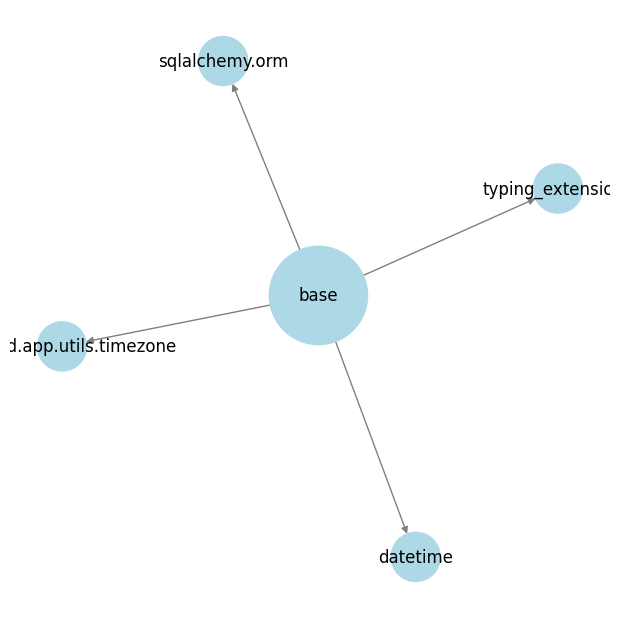

In [ ]:
# Single file and its imports
file_path = "/content/fastapi_best_architecture/backend/app/models/base.py"
single_file_graph = SingleFileImportGraph(file_path)
single_file_graph.draw_with_centrality()